# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import csv

#  Feature Selection

In [2]:
def train_test_split(data_set, test_ratio, seed):

    df = pd.DataFrame(data_set)
    df = pd.get_dummies(data=df, columns=[34])
    train_set = df.sample(frac=test_ratio, random_state=seed)
    test_set = df.drop(train_set.index)
    return np.array(train_set), np.array(test_set)


def select_feat(train_data, test_data, select_all=True):

    y_train, y_test = train_data[:, 34:36], test_data[:, 34:36]
    raw_x_train, raw_x_test = np.delete(train_data, [34,35], 1), np.delete(test_data, [34,35], 1)

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4]
        
    return raw_x_train[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_test


data = pd.read_csv('ionosphere_data.csv', header=None)
train_data, test_data = train_test_split(data, 0.8, 100)
x_train, x_test, y_train, y_test = select_feat(train_data, test_data, select_all=True)


print('train_data =', train_data.shape)
print('test_data =', test_data.shape)
print('x_train =', x_train.shape)
print('x_test =', x_test.shape)
print('y_train =', y_train.shape)
print('y_test =', y_test.shape)



train_data = (281, 36)
test_data = (70, 36)
x_train = (281, 34)
x_test = (70, 34)
y_train = (281, 2)
y_test = (70, 2)


# Useful Functions

In [3]:
def calc_rmse(y_true, y_pred):
    return np.square(np.subtract(y_true, y_pred)).mean() ** 0.5

def softmax(x):
    a = np.max(x, axis=1, keepdims=True)
    e_x = np.exp(x - a)
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy(F, y):
    m = len(F)
    return -(1./m) * np.sum(np.multiply(y, np.log(F)))


# Classification

In [7]:
class ClassificationTwoLayerNN(object):

    def __init__(self, input_size, hidden_size, num_classes, std=1e-4):  

        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)  
        self.params['b1'] = np.zeros((1, hidden_size)) 
        self.params['W2'] = std * np.random.randn(hidden_size, num_classes) 
        self.params['b2'] = np.zeros((1, num_classes))


    def loss(self, X, y=None, reg=0.0):

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape  

        # forward
        Z1 = np.dot(X, W1) + b1
        A1 = np.maximum(0, Z1)
        Z2 = np.dot(A1, W2) + b2
        out = softmax(Z2)

        # Compute the loss
        loss = cross_entropy(out, y)
        # loss = loss / N + 0.5 * reg * (np.sum(W1 ** 2) + np.sum(W2 ** 2))


        # backward
        grads = {}

        dZ2 = (out - y) / len(X)
        grads['W2'] = np.dot(A1.T, dZ2) + 2*reg*W2
        grads['b2'] = np.sum(dZ2, axis=0, keepdims=True)
        
        dA1 = np.dot(dZ2, W2.T)
        dA1[A1 <= 0] = 0

        dZ1 = dA1
        grads['W1'] = np.dot(X.T, dZ1) + 2*reg*W1
        grads['b1'] = np.sum(dZ1, axis=0, keepdims=True)

        return loss, grads


    def train(self, X, y, X_test, y_test,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100000,
            batch_size=32, verbose=False):


        num_train = X.shape[0]
        iterations_per_epoch = math.floor(num_train / batch_size)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        epoch_loss_history = []
        Z2_history = []


        for it in range(num_iters):

            X_batch = None
            y_batch = None

            indices = np.random.choice(a=num_train, size=batch_size, replace=True)
            X_batch = X[indices]
            y_batch = y[indices]


            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X=X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)


            # upgrades
            self.params['W1'] += -learning_rate * grads['W1']
            self.params['W2'] += -learning_rate * grads['W2']
            self.params['b1'] += -learning_rate * grads['b1']
            self.params['b2'] += -learning_rate * grads['b2']


            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))


            # Every epoch, check train and test accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:

                epoch_loss_history.append(loss)
                Z2_history.append(self.plot_layer(X))

                # Decay learning rate
                # learning_rate *= learning_rate_decay

        return {'loss_history': loss_history, 'epoch_loss_history': epoch_loss_history, 'Z2_history': Z2_history}


    def predict(self, X):

        Z1 = np.dot(X, self.params['W1']) + self.params['b1']
        A1 = np.maximum(0, Z1)
        Z2 = np.dot(A1, self.params['W2']) + self.params['b2']
        out = softmax(Z2)
        y_pred = np.argmax(out, axis=1)

        return y_pred

    def plot_layer(self, X):

        Z1 = np.dot(X, self.params['W1']) + self.params['b1']
        A1 = np.maximum(0, Z1)
        Z2 = np.dot(A1, self.params['W2']) + self.params['b2']

        return Z2

In [8]:
nn = ClassificationTwoLayerNN(input_size=34, hidden_size=128, num_classes=2)

# Train the network
result = nn.train(x_train, y_train, x_test, y_test,
                  num_iters=50000, batch_size=20,
                  learning_rate=1e-2, learning_rate_decay=0.95,
                  reg=0, verbose=True)

iteration 0 / 50000: loss 0.693147
iteration 100 / 50000: loss 0.704959
iteration 200 / 50000: loss 0.673931
iteration 300 / 50000: loss 0.712592
iteration 400 / 50000: loss 0.742920
iteration 500 / 50000: loss 0.624773
iteration 600 / 50000: loss 0.623513
iteration 700 / 50000: loss 0.648961
iteration 800 / 50000: loss 0.724311
iteration 900 / 50000: loss 0.751638
iteration 1000 / 50000: loss 0.697071
iteration 1100 / 50000: loss 0.647523
iteration 1200 / 50000: loss 0.643155
iteration 1300 / 50000: loss 0.628074
iteration 1400 / 50000: loss 0.505015
iteration 1500 / 50000: loss 0.687437
iteration 1600 / 50000: loss 0.714510
iteration 1700 / 50000: loss 0.583618
iteration 1800 / 50000: loss 0.481423
iteration 1900 / 50000: loss 0.630451
iteration 2000 / 50000: loss 0.425408
iteration 2100 / 50000: loss 0.553367
iteration 2200 / 50000: loss 0.487888
iteration 2300 / 50000: loss 0.406365
iteration 2400 / 50000: loss 0.319056
iteration 2500 / 50000: loss 0.413365
iteration 2600 / 50000: 

In [9]:
# Predict
test_predict_list = nn.predict(x_test).tolist()
train_predict_list = nn.predict(x_train).tolist()

# good [0, 1] bad[1, 0]
y_test_list = []
for i in range(0, y_test.shape[0]):
    if y_test[i][0] == 0:
        y_test_list.append(1) # good
    else:
        y_test_list.append(0) # bad

y_train_list = []
for i in range(0, y_train.shape[0]):
    if y_train[i][0] == 0:
        y_train_list.append(1) # good
    else:
        y_train_list.append(0) # bad


count_test = 0
for i in range(0, len(test_predict_list)):
    if test_predict_list[i] != y_test_list[i]:
        count_test += 1

count_train = 0
for i in range(0, len(train_predict_list)):
    if train_predict_list[i] != y_train_list[i]:
        count_train += 1

print('test error rate =', count_test / len(test_predict_list))
print('train error rate =', count_train / len(train_predict_list))


test error rate = 0.08571428571428572
train error rate = 0.0035587188612099642


Text(0, 0.5, 'loss')

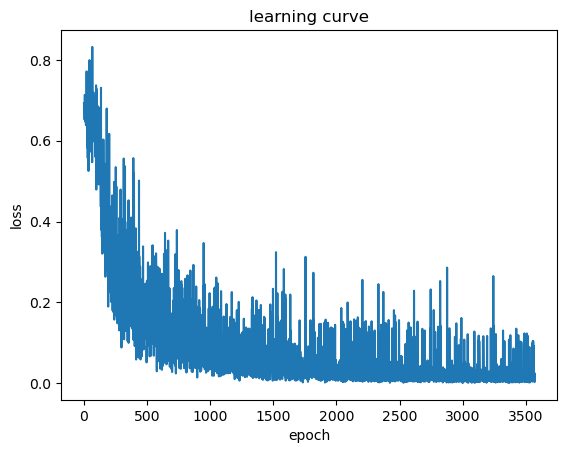

In [10]:
# Plot the training curve

plt.plot(result['epoch_loss_history'])
plt.title('learning curve')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0.5, 1.0, '2D feature after training')

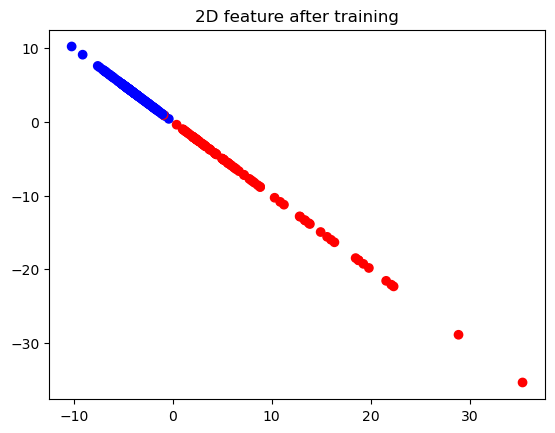

In [12]:
out = nn.plot_layer(x_train)

y_train_color_list = []
for i in y_train_list:
    if i == 1:
        y_train_color_list.append('blue') # good
    else:
        y_train_color_list.append('red')  # bad


plt.scatter(out[:,-2], out[:, -1], color=y_train_color_list)
plt.title('2D feature after training')

Text(0.5, 1.0, '2D feature 3 epoch')

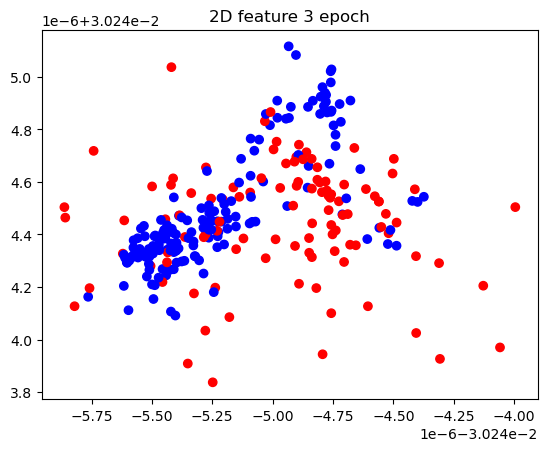

In [15]:
x = result['Z2_history'][2][:,-2]
y = result['Z2_history'][2][:, -1]

plt.scatter(x, y, color=y_train_color_list)
plt.title('2D feature 3 epoch')

